In [121]:
from glob import glob
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import pandas as pd
import copy

# statistics
from astropy.stats import biweight_location, biweight_scale, sigma_clipped_stats
from scipy.stats import median_abs_deviation

# configuration
np.set_printoptions(linewidth=120) # para que se vea
plt.rcParams["image.cmap"] = "gray" # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.rcParams["image.origin"] = "lower"

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

# M-92, imágenes desde KPNO 

Para cada parte del ejercicio, agregue tantas celdas de código o de Markdown como considere necesario.

## 1) Información

Obtenga el tipo de imagen, el objeto, y después el filtro de cada una de las imágenes en la carpeta `data/m92`.

Organice esta información como crea conveniente, ya sea en diferentes variables, en diccionarios, o en un DataFrame.

¿Por qué el bias no tiene filtro asignado?

In [215]:
files = glob("data/m92/*.fit")
files

In [123]:
#{nombre imagen: [objecto, tipo]}
file_info = {}
for file in files:
    object = fits.getheader(file)['OBJECT']
    type = fits.getheader(file)['IMAGETYP']
    naxis1 = fits.getheader(file)['NAXIS1']
    data = fits.getdata(file)
    file_info[file] = [object, type, data, naxis1] 


## 2) Visualización

Importe todas las imágenes con `fits.getdata`. Organice estas imágenes como considere necesario, siguendo el mismo esquema que usó en el primer punto.

Haga un subplot para visualizar todas las imágenes. Puede usar la función `quantile_imshow` que usamos para el primer laboratorio.

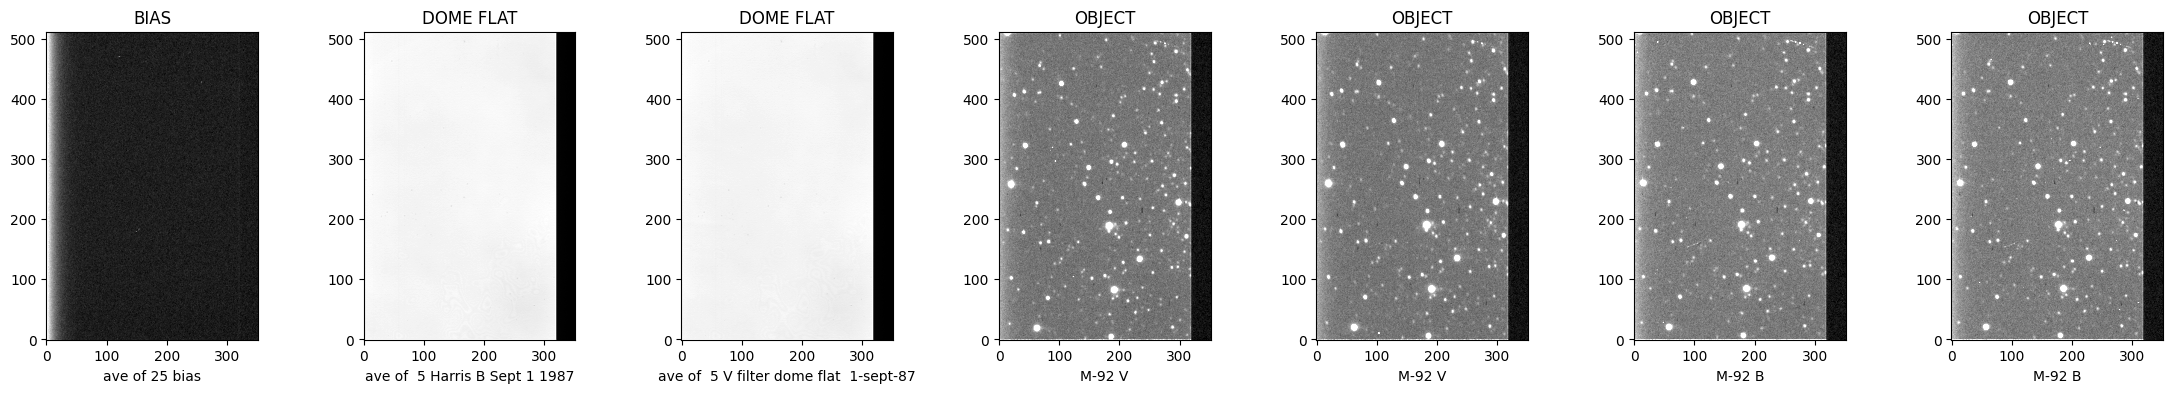

In [124]:
fig, ax = plt.subplots(ncols=len(file_info.keys()), figsize=(4*len(file_info.keys()), 4))

for index, filename in enumerate(file_info.keys()):
    plt.sca(ax[index])
    plt.title(file_info[filename][1])
    plt.xlabel(file_info[filename][0])
    quantile_imshow(file_info[filename][2])

plt.savefig('overscan.jpeg')

## 3) Recorte

Estas imágenes tienen algo llamado _"overscan"_. Discuta brevemente qué entiende de este término, según la explicación del profesor.

### 3.A) detalle del overscan

Grafique el promedio de los pixeles en X (`np.mean(...,axis=0)`) contra los pixeles en Y (`NAXIS1`).
Haga un zoom de su gráfica de promedio a la región de overscan. Para esto puede usar `plt.xlim` y `plt.ylim`.

Determine la región de overscan: píxel inicial y pixel final. Guarde esta información como lo considere conveniente.

Obtenga estadísticas (localización y escala) de las regiones de overscan de al menos dos de las imágenes. 
¿Qué medida de localización y de escala va a usar, y por qué?

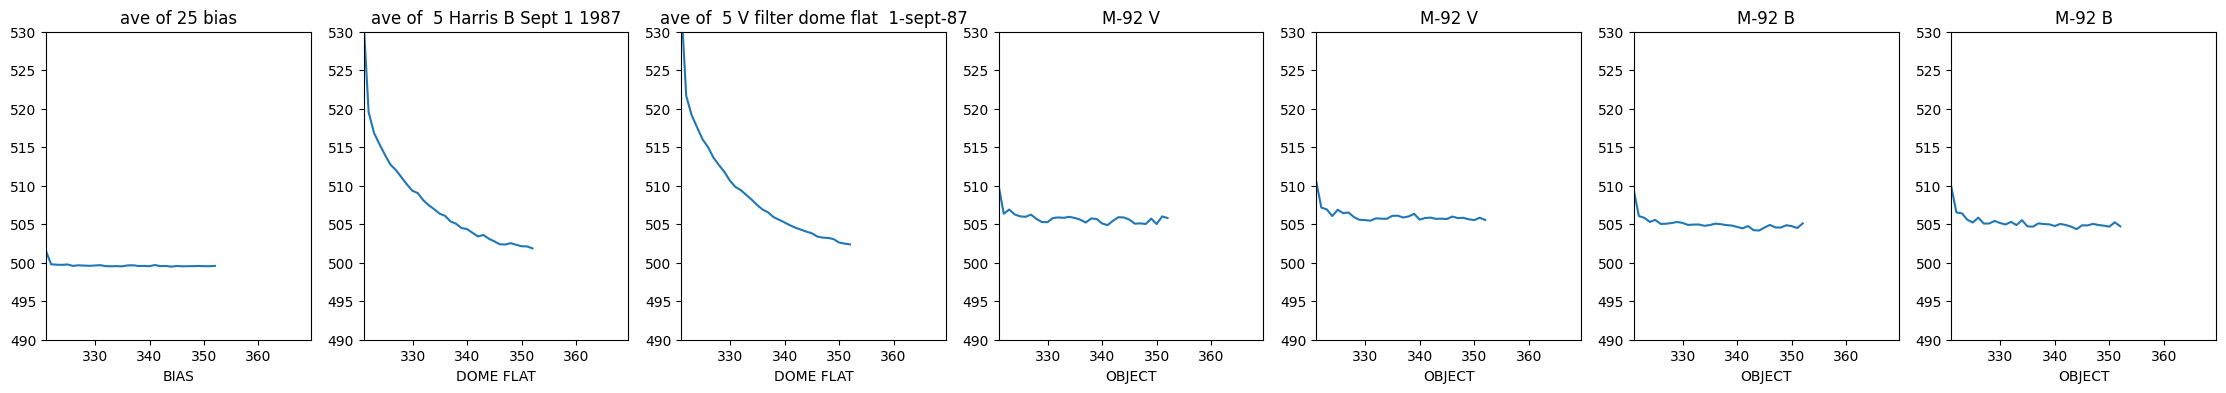

In [125]:
fig, ax = plt.subplots(ncols=len(file_info.keys()), figsize=(4*len(file_info.keys()), 4))

for index, filename in enumerate(file_info.keys()):
    plt.sca(ax[index])
    plt.xlabel(file_info[filename][1])
    plt.title(file_info[filename][0])
    
    X = np.mean(file_info[filename][2], axis=0)
    leng = file_info[filename][3]
    Y = np.linspace(0,leng,leng)
    
    plt.plot(Y,X)
    plt.xlim(321)
    plt.ylim(490,530)

In [126]:
for index, filename in enumerate(file_info.keys()):
  
  flattened = file_info[filename][2][:,321:].ravel()
  file_info[filename].append(round(np.mean(flattened),2))
  file_info[filename].append(round(np.std(flattened)))

### 3.B) imágenes recortadas

Remueva la región de overscan (determinada en el punto anterior) de todas las imágenes. No las modifique, sino que haga copias y guarde las imágenes recortadas como considere.

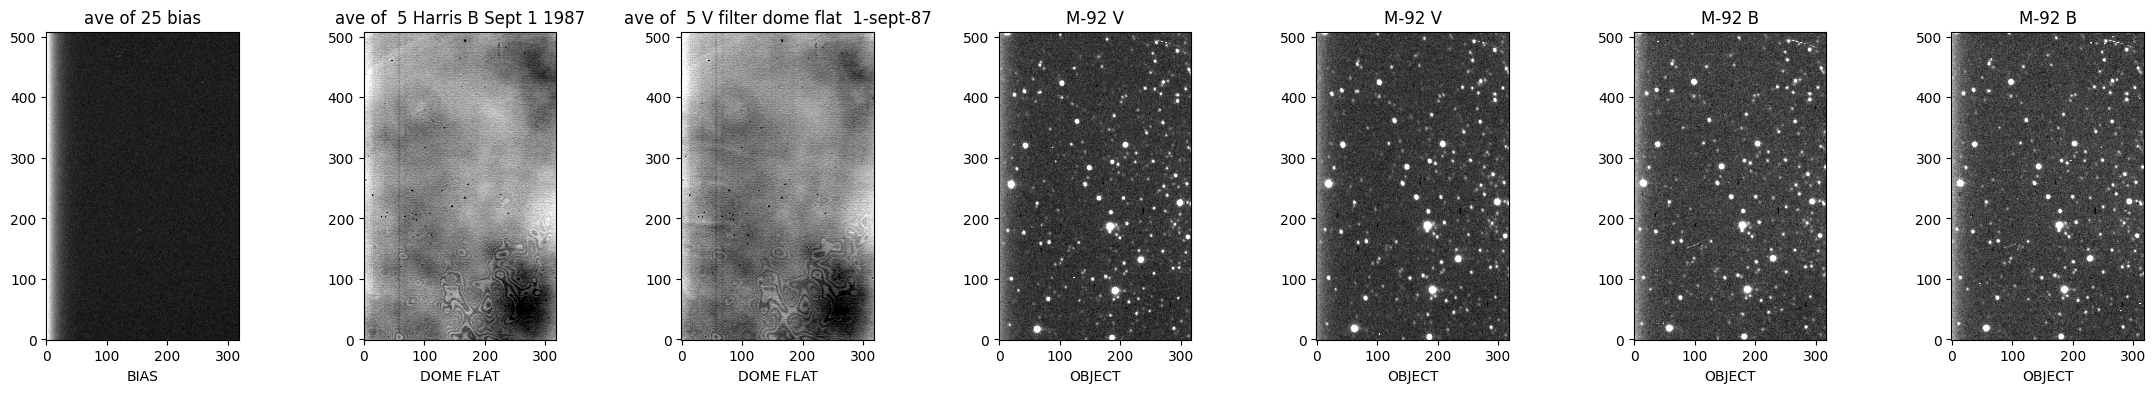

In [127]:
file_info_overscan = copy.deepcopy(file_info)

fig, ax = plt.subplots(ncols=len(file_info.keys()), figsize=(4*len(file_info.keys()), 4))

for index, filename in enumerate(file_info_overscan.keys()):
    plt.sca(ax[index])
    plt.xlabel(file_info_overscan[filename][1])
    plt.title(file_info_overscan[filename][0])
    
    file_info_overscan[filename][2] = file_info_overscan[filename][2][2:-1,:318]
    
    quantile_imshow(file_info_overscan[filename][2])

## 4) Bias

Remueva la imagen de bias de todas las imágenes, sean flat o ciencia. De nuevo, no las modifique, haga copias, y organice como considere.

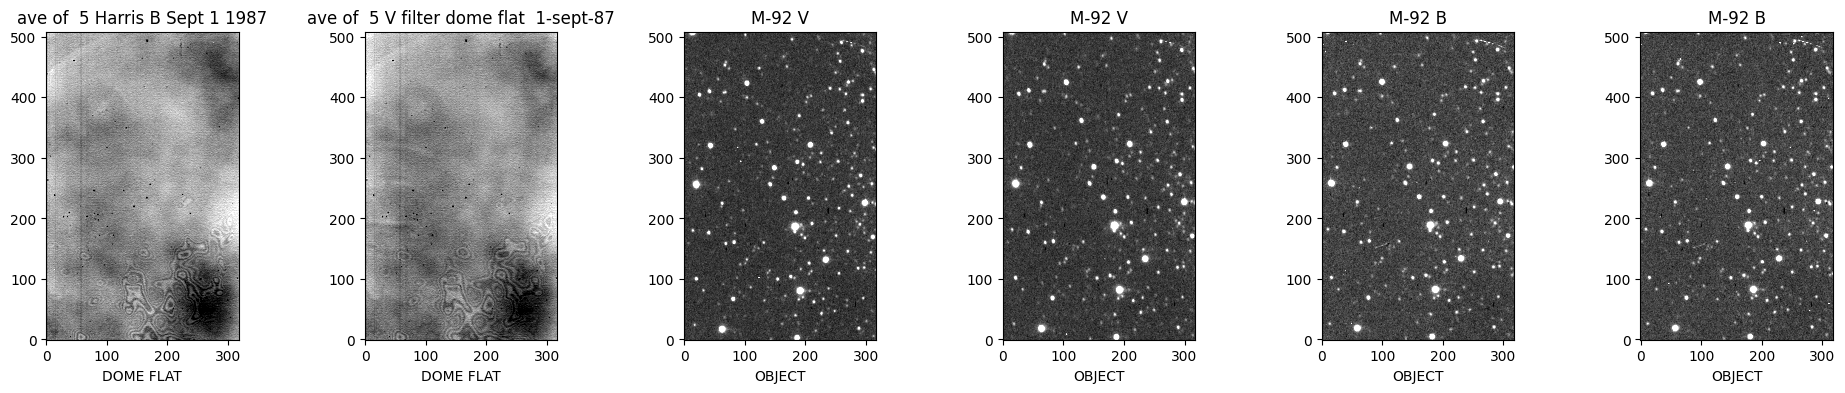

In [137]:
file_info_bias = copy.deepcopy(file_info_overscan)

fig, ax = plt.subplots(ncols=len(file_info.keys())-1, figsize=(4*(len(file_info.keys())-1), 4))

bias = []
for index, filename in enumerate(file_info_bias.keys()):
    if file_info_bias[filename][1] == 'BIAS':
        bias = file_info_bias[filename][2]
 
    elif file_info_bias[filename][1] != 'BIAS':
        plt.sca(ax[index-1])
        plt.xlabel(file_info_bias[filename][1])
        plt.title(file_info_bias[filename][0])
        
        file_info_bias[filename][2] = file_info_bias[filename][2] - bias
        
        quantile_imshow(file_info_bias[filename][2])

### 4.extra) comparación con el overscan

Compare los valores del bias con las estádisticas que obtuvo del overscan, y comente.

Elegimos una imagen para estudiar las estadísticas.

(512, 352)

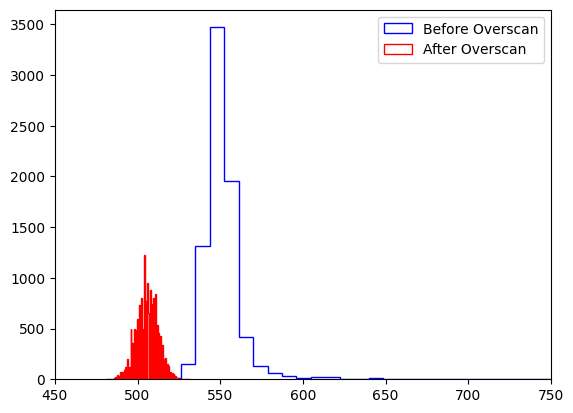

In [165]:
datos_histograma_antes = file_info['data/m92\\m92_4.fit'][2][:,300:315]
datos_histograma_despues = file_info['data/m92\\m92_4.fit'][2][:,321:350]

plt.hist(datos_histograma_antes.ravel(), bins=100, histtype='step',color='b',label='Before Overscan')
plt.hist(datos_histograma_despues.ravel(), bins=100, histtype='step',color='r',label='After Overscan')
plt.xlim(450,750)
plt.legend()

file_info['data/m92\\m92_4.fit'][2].shape

## 5) Flat

Normalice las imágenes flat (de nuevo, ¿qué medida de localización va a usar, y por qué?), y aplique el flat a las imágenes ciencia, teniendo cuidado de usar el filtro apropiado.

In [185]:
flat_B = file_info_bias['data/m92\\m92_2.fit']
flat_V = file_info_bias['data/m92\\m92_3.fit']

Text(0.5, 1.0, 'Flats')

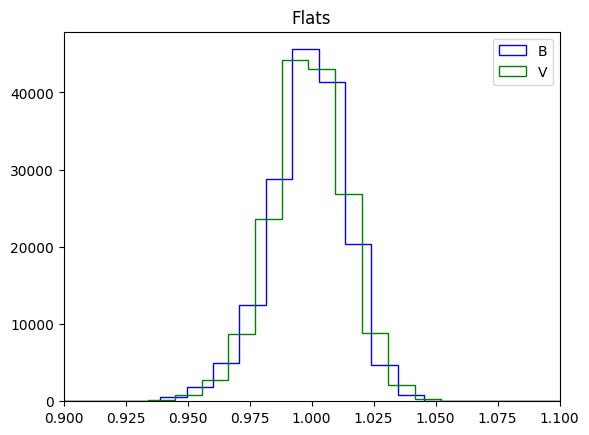

In [231]:
flat_B_norm = np.array(flat_B[2])/np.mean(flat_B[2])
flat_V_norm = np.array(flat_V[2])/np.mean(flat_V[2])

plt.hist(flat_B_norm.ravel(), bins=100, histtype='step',color='b',label='B')
plt.hist(flat_V_norm.ravel(), bins=100, histtype='step',color='green',label='V')
plt.xlim(0.9,1.1)
plt.legend()
plt.title('Flats')

In [187]:
Science1_V = file_info_bias['data/m92\\m92_4.fit'][2] / flat_V_norm
Science2_V = file_info_bias['data/m92\\m92_5.fit'][2] / flat_V_norm

Science1_B = file_info_bias['data/m92\\m92_6.fit'][2] / flat_B_norm
Science2_B = file_info_bias['data/m92\\m92_7.fit'][2] / flat_B_norm

Science = {'data/m92\\m92_4.fit': Science1_V,
           'data/m92\\m92_5.fit': Science2_V,
           'data/m92\\m92_6.fit':Science1_B, 
           'data/m92\\m92_7.fit': Science2_B}

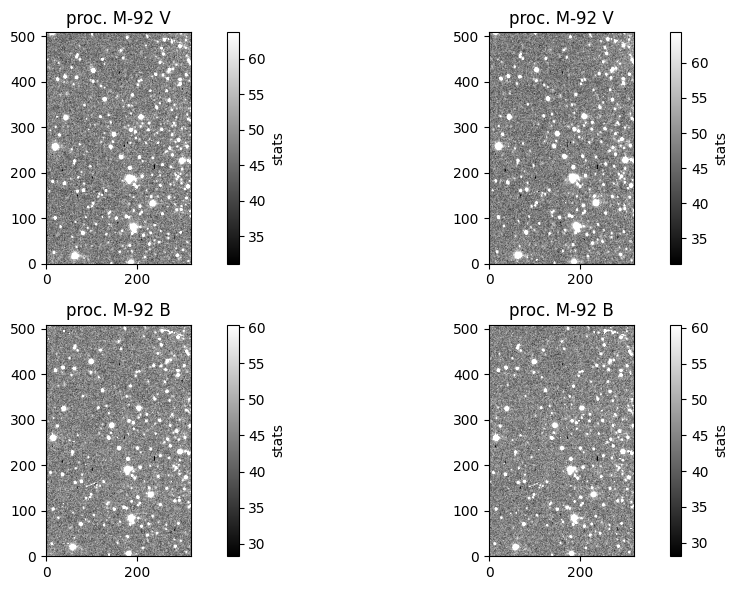

In [233]:
Science = {'data/m92\\m92_4.fit': Science1_V,
           'data/m92\\m92_5.fit': Science2_V,
           'data/m92\\m92_6.fit':Science1_B, 
           'data/m92\\m92_7.fit': Science2_B}

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

for i, (img, ax) in enumerate(zip(Science.keys(), axs.flatten())):
    plt.sca(ax)
    quantile_imshow(Science[img], upper=0.95)
    plt.title("proc. " + file_info_bias[img][0])
    cbar = plt.colorbar()
    cbar.set_label('stats') 
    plt.tight_layout()
    
plt.savefig('laqsi.png')
    

## 6) Guardar las imágenes calibradas

Primero, copie los headers originales de las imágenes ciencia, y agregue un comentario describiendo **_muy brevemente_** el proceso de reducción realizado.

Para guardar sus resultados en formato fits, para cada imagen ciencia calibrada, use la función `fits.PrimaryHDU`. 
Use los headers que contienen su comentario.

Una vez obtenido el objeto `PrimaryHDU`, use el método `hdu.writeto`. Ponga un nombre descriptivo, pero corto, a las imágenes resultantes.

In [227]:
headers = {}
for file in files:
    if fits.getheader(file)['IMAGETYP'] != 'BIAS' and fits.getheader(file)['IMAGETYP'] != 'DOME FLAT':
        header = fits.getheader(file).copy()
        header['REDUC'] = 'The processing involved removing overscan, subtracting bias, normalizing flats, and dividing all images by the normalized flat'
        headers[file] = header
    
he = 'data/m92\\m92_4.fit'
he = he.replace('data/m92\\', '')
he

'm92_4.fit'

In [230]:
for i, file in enumerate(headers.keys()):
    hdu = fits.PrimaryHDU(data= file_info_bias[file][2],header= headers[file])
    name = file.replace('data/m92\\', '')
    hdu.writeto(f'proc_{name}', overwrite=True) 